In [1]:
from ag3 import release_data
v3 = release_data()

In [2]:
import pandas as pd
import numpy as np
import allel
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sns

In [4]:
# kubernetes cluster setup
n_workers = 20
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.scale_up(n_workers)
#cluster.adapt(minimum=1, maximum=n_workers)
cluster

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.10:39587
distributed.scheduler - INFO -   dashboard at:                    :42993


In [5]:
# dask client setup
from dask.distributed import Client, progress
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-00318258-07c2-11eb-8415-faca4548bb18
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.35.63.10:39587 Dashboard: /user/nicholasharding/proxy/42993/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
genome = {
    "2R": 61545105,
    "3R": 53200684,
    "2L": 49364325,
    "UNKN": 42389979,
    "3L": 41963435,
    "X": 24393108,
#    "Y_unplaced": 237045,
#    "Mt": 15363
}

In [7]:
window_size = 100_000

In [8]:
cached_fn = Path(f"../content/tables/accessibility/accessibility_summary_{str(window_size)}.csv")

In [9]:
if not cached_fn.is_file():
    accessibility_stats = {}
    # accessibility
    # load_mask
    for chrom in ["2R", "2L", "3R", "3L", "X"]:

        if chrom in accessibility_stats:
            continue

        pos = allel.SortedIndex(v3.load_variants(chrom))

        windows = allel.stats.window.position_windows(pos, size=window_size, start=1, stop=pos[-1], step=window_size)
        windows = list(windows)
        df = pd.DataFrame(windows, columns=["start", "stop"])

        win_size = df["stop"] - df["start"] + 1

        for mask in "gamb_colu", "arab", "gamb_colu_arab":

            mask_a = v3.load_mask(chrom, mask)
            out, windows, counts = allel.windowed_statistic(pos, mask_a, np.sum, windows=windows)
            df[mask] = out / win_size

        accessibility_stats[chrom] = df

    all_df = pd.concat(accessibility_stats)
    all_df.to_csv(cached_fn)
    
else:
    all_df = pd.read_csv(cached_fn, index_col=[0, 1])

distributed.scheduler - INFO - Register tcp://10.33.5.3:39333
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.5.3:39333
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.18.3:36017
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.18.3:36017
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.16.3:45831
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.16.3:45831
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.13.3:44199
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.13.3:44199
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.229.3:42741
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.229.3:42741
distributed.core - INFO

In [10]:
autosomes = '2R', '2L', '3R', '3L'
chromosomes = autosomes + ('X',) 

class GenomeFigure(object):
    
    def __init__(self, genome, *args, **kwargs):
        self.chromosomes = kwargs.pop('chromosomes', ['2R', '2L', '3R', '3L', 'X', 'UNKN'])
        maxchrsize = max(genome[chrom] for chrom in self.chromosomes)
        fig = plt.figure(*args, **kwargs)
        self.fig = fig
        self.ax = dict()
        for i, chrom in enumerate(self.chromosomes):
            ax = fig.add_subplot(3, 2, i+1)
            self.ax[chrom] = ax
            S = np.arange(1, genome[chrom], 1, dtype=np.int64)
            if i % 2 == 1:
                sns.despine(ax=ax, offset=10, top=True, left=True, right=False)
                ax.set_xlim(0, maxchrsize)
                ax.yaxis.tick_right()
                ax.yaxis.set_label_position('right')
            else:
                ax.set_xlim((S.size)-(maxchrsize), S.size)
                ax.yaxis.tick_left()
                sns.despine(ax=ax, offset=10, top=True, left=False, right=True)
            ax.set_xticks(range(0, S.size, int(5e6)))
            ax.set_xticklabels(range(0, int(S.size/1e6), 5))
            ax.set_title(chrom, fontweight='bold')
            ax.xaxis.tick_bottom()
        fig.tight_layout()
        
    def apply(self, f, **kwargs):
        chromosomes = kwargs.pop('chromosomes', self.chromosomes)
        for chrom in chromosomes:
            ax = self.ax[chrom]
            f(chrom, ax, **kwargs)
        
        
def subplots(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    sns.despine(ax=ax, offset=10)
    return fig, ax

In [11]:
from matplotlib.ticker import MultipleLocator

In [12]:
def plot_accessibility_summary(chrom, ax, species="gamb_colu", **kwargs):
    
    if isinstance(species, list) and chrom == 'UNKN':
        # ie draw legend
        pal = sns.color_palette('muted', len(species))
        ax.axis("off")
        ax.set_title("")

        l = [mlines.Line2D([], [], color=pal[i], label=sp) for i, sp in enumerate(species)]
        ax.legend(handles=l, loc='center')
        return None
        
    elif isinstance(species, list):
        pal = sns.color_palette('muted', len(species))
        for i, sp in enumerate(species):
            y = all_df.loc[chrom][sp]
            ax.plot(all_df.loc[chrom].start.values, y, color=pal[i], label=sp)
         
    elif chrom == "UNKN":
        ax.axis("off")
        ax.set_title("")
        return None
    
    else:
        x = all_df.loc[chrom].start.values    
        y = all_df.loc[chrom][species]
        ax.plot(x, y)
    
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))


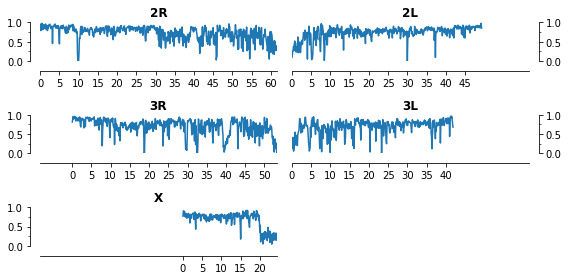

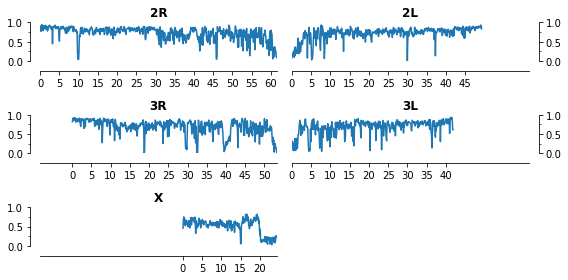

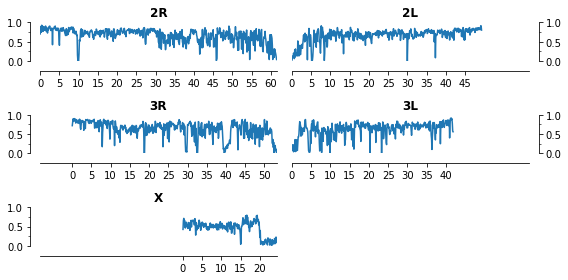

In [13]:
for species_id in ["gamb_colu", "arab", "gamb_colu_arab"]:

    g = GenomeFigure(genome, figsize=(8, 4))
    g.apply(plot_accessibility_summary, species=species_id)

    g.fig.savefig(f"../content/images/accessibility/genomewide_accessibility_{species_id}.svg")

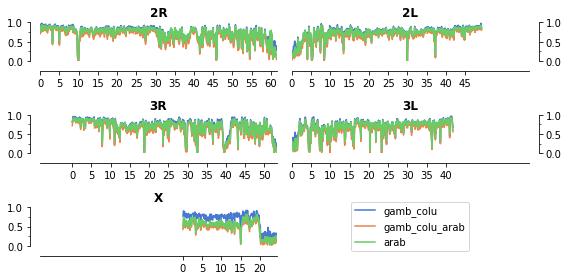

In [14]:
species_ = ["gamb_colu", "gamb_colu_arab", "arab"]

g = GenomeFigure(genome, figsize=(8, 4))
g.apply(plot_accessibility_summary, species=species_)
g.fig.savefig(f"../content/images/accessibility/genomewide_accessibility_{''.join(species_)}.svg", dpi=300)

## Divergence

- for each species, calculate divergence from PEST. 
- that is gamb_colu, gamb, colu, arab

For this analysis, do not apply masks.

In [15]:
meta_df = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [16]:
meta_df

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC0295-C,K92,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.026,0.002,gamb_colu,gambiae,False,True,True,False
AC0296-C,K93,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.029,0.003,gamb_colu,gambiae,False,True,True,False
AC0297-C,K94,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.026,0.002,gamb_colu,gambiae,False,True,True,False


In [17]:
gamb_colu_sel = meta_df.species_gambcolu_arabiensis.values == "gamb_colu"
gamb_sel = meta_df.species_gambiae_coluzzii.values == "gambiae"
colu_sel = meta_df.species_gambiae_coluzzii.values == "coluzzii"
arab_sel = meta_df.species_gambcolu_arabiensis == "arabiensis"

In [18]:
cached_fn = Path(f"../content/tables/divergence/divergence_summary_{str(window_size)}.csv")

In [19]:
if not cached_fn.is_file():
    div_stats = {}
    # accessibility
    # load_mask
    for chrom in ["2R", "2L", "3R", "3L", "X"]:

        pos = allel.SortedIndex(v3.load_variants(chrom))

        windows = allel.stats.window.position_windows(pos, size=window_size, start=1, stop=pos[-1], step=window_size)
        windows = list(windows)
        df = pd.DataFrame(windows, columns=["start", "stop"])

        win_size = df["stop"] - df["start"] + 1
        
        gt = allel.GenotypeDaskArray(v3.load_sample_set_calldata(chrom, v3.all_wild_sample_sets))

        for species_label, selection in zip(
            ["gamb_colu", "gamb", "colu", "arab"],
            [gamb_colu_sel, gamb_sel, colu_sel, arab_sel]):
                            
            div = gt.compress(selection, axis=1).to_n_alt().sum(axis=1).compute() / selection.sum()
            
            out, windows, counts = allel.windowed_statistic(
                pos, div, np.mean, windows=windows)
            df[species_label] = out

        div_stats[chrom] = df

    all_div_df = pd.concat(div_stats)
    all_div_df.to_csv(cached_fn)
    
else:
    all_div_df = pd.read_csv(cached_fn, index_col=[0, 1])

distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage co

In [20]:
def plot_divergence_summary(chrom, ax, species="gamb_colu", **kwargs):
    
    if isinstance(species, list) and chrom == 'UNKN':
        # ie draw legend
        pal = sns.color_palette('muted', len(species))
        ax.axis("off")
        ax.set_title("")

        l = [mlines.Line2D([], [], color=pal[i], label=sp) for i, sp in enumerate(species)]
        ax.legend(handles=l, loc='center')
        return None
        
    elif isinstance(species, list):
        pal = sns.color_palette('muted', len(species))
        for i, sp in enumerate(species):
            y = all_div_df.loc[chrom][sp]
            ax.plot(all_div_df.loc[chrom].start.values, y, color=pal[i], label=sp)
         
    elif chrom == "UNKN":
        ax.axis("off")
        ax.set_title("")
        return None
    
    else:
        x = all_div_df.loc[chrom].start.values    
        y = all_div_df.loc[chrom][species]
        ax.plot(x, y)
    
    ax.set_ylim([0, .1])
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))

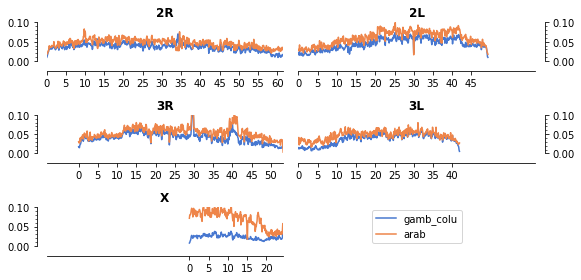

In [21]:
g = GenomeFigure(genome, figsize=(8, 4))
g.apply(plot_divergence_summary, species=["gamb_colu", "arab"])
g.fig.savefig(f"../content/images/divergence/genomewide_divergence_gamb_colu_vs_arab.svg")

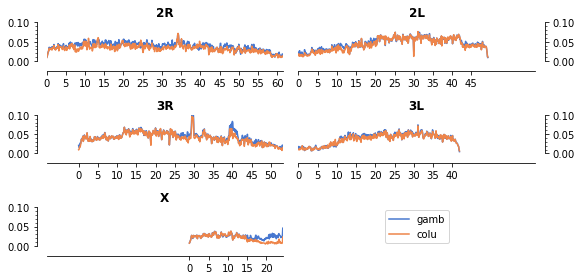

In [22]:
g = GenomeFigure(genome, figsize=(8, 4))
g.apply(plot_divergence_summary, species=["gamb", "colu"])

g.fig.savefig(f"../content/images/divergence/genomewide_divergence_gamb_vs_colu.svg")

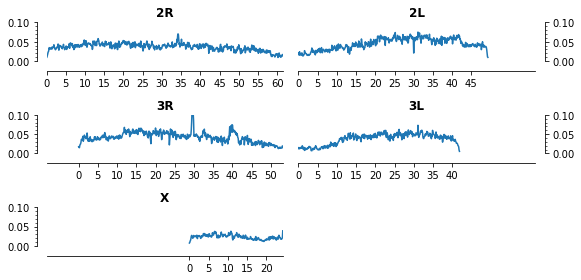

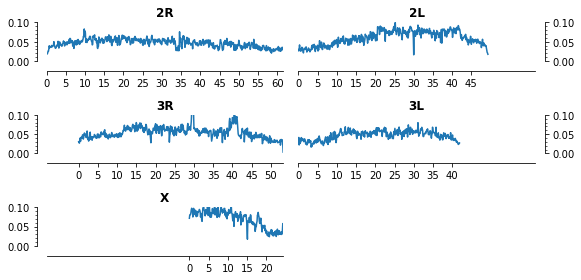

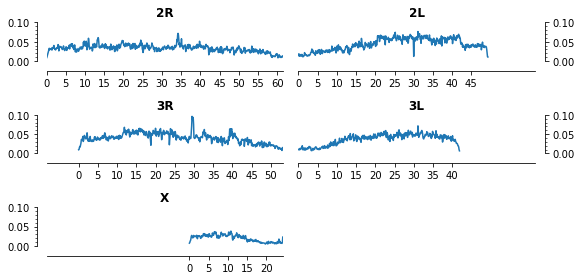

distributed.scheduler - INFO - Register tcp://10.33.21.2:34093
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.21.2:34093
distributed.core - INFO - Starting established connection


In [23]:
for species_id in ["gamb_colu", "arab", "colu"]:

    g = GenomeFigure(genome, figsize=(8, 4))
    g.apply(plot_divergence_summary, species=species_id)

    #g.fig.savefig(f"../content/images/genomewide_accesibility_{species_id}.svg")